### Setup

In [ ]:
using Pkg

# Pkg.add(url="https://github.com/mppmu/BoostFractor.jl.git")
# Pkg.add(url="https://github.com/bergermann/Dragoon.jl.git")
Pkg.update()

In [24]:
using Dragoon
using Plots
using Dates

In [32]:
#number of discs in the booster
n = 20

#initial disc configuration
#findpeak tries to find an equidistant configuration with a peak at f
initdist = findpeak(22.025e9,n)

#generate frequencies for calculation and for plotting
freqs = genFreqs(22.025e9,50e6; length=10) #optimize on these frequencies
freqsplot = genFreqs(22.025e9,150e6; length=1000)

#initialize physical properties of the booster
booster = AnalyticalBooster(initdist)
booster.timestamp = DateTime(0)
#=
Booster(
    pos,              disc positions
    ndisk,            disc number
    thickness,        disc thickness
    epsilon,          disc epsilon
    vmotor,           motor speed
    maxlength,        maximum allowed booster length (not implemented yet)
    timestamp,        booster operation time
    summedtraveltime, summed motor operation time
    codetimestamp     code runtime
)
=#

#initialize storage of measurements
hist = initHist(booster,100000,freqs,ObjAnalytical)
#                           ^ length, should be at least the larger of (n^2, search steps)
;

Objective Value: -243.3, Timestamp: 0000-01-01T00:00:00


In [33]:
α = booster.vmotor*1e-3

objFunction = ObjAnalytical
solver = SolverNewton("inv")
derivator = Derivator2(1e-5,1e-6,"double")
step = StepNorm("unit")
search = SearchExtendedSteps(20000)

p = zeros(booster.ndisk)
g = zeros(booster.ndisk)
h = zeros(booster.ndisk,booster.ndisk)

updateHist!(booster,hist,freqs,objFunction)

derivator.func(g,h,booster,hist,freqs,objFunction,derivator.args)

display(g); display(h)

solver.func(p,g,h,0,0,solver.args)

println("Gradient norm: ",round(pNorm(g),sigdigits=3))

updateHist!(booster,hist,freqs,objFunction)

step.func(p,α,booster,hist,freqs,objFunction,step.args)

updateHist!(booster,hist,freqs,objFunction)

k = search.func(-p,α,booster,hist,freqs,objFunction,search.args)

20-element Vector{Float64}:
       1.172259922511597e6
       1.3621222594415839e6
       1.4067977735977848e6
       1.2913148034140249e6
       1.0219178004336256e6
  625438.7503142765
  145594.43266451807
 -363011.54934549937
 -842014.6635360054
      -1.236510959426141e6
      -1.5017226790724648e6
      -1.6086437626539718e6
      -1.5480509099341857e6
      -1.3320708223026115e6
 -992674.7903975367
 -577126.6084924107
 -141184.30231015678
  258717.45742559395
  573129.2113975214
  766175.3401058959

20×20 Matrix{Float64}:
 -1.13652e13  -5.17149e9   -6.66812e9   …  -1.53564e9   -3.26113e9
 -5.17149e9   -4.10286e12  -7.60794e9      -1.87565e9   -3.82256e9
 -6.66812e9   -7.60794e9   -4.24792e12     -2.05048e9   -3.99158e9
 -7.43909e9   -8.44713e9   -8.48817e9      -2.01767e9   -3.71884e9
 -7.35717e9   -8.31262e9   -8.30117e9      -1.76081e9   -3.0116e9
 -6.40487e9   -7.18964e9   -7.12067e9   …  -1.29232e9   -1.93355e9
 -4.6775e9    -5.19181e9   -5.06757e9      -6.52286e8   -5.97445e8
 -2.3722e9    -2.54791e9   -2.37794e9       9.60997e7    8.48651e8
  2.3615e8     4.2614e8     6.2603e8        8.74156e8    2.23993e9
  2.82979e9    3.36746e9    3.57706e9       1.59736e9    3.41603e9
  5.08978e9    5.91385e9    6.11113e9   …   2.18599e9    4.24218e9
  6.73923e9    7.75299e9    7.91695e9       2.5754e9     4.62737e9
  7.58193e9    8.66594e9    8.7794e9        2.72461e9    4.53673e9
  7.53004e9    8.55816e9    8.6099e9        2.62189e9    3.99624e9
  6.61633e9    7.47258e9    7.45878e9   

Gradient norm: 4.69e6


4558

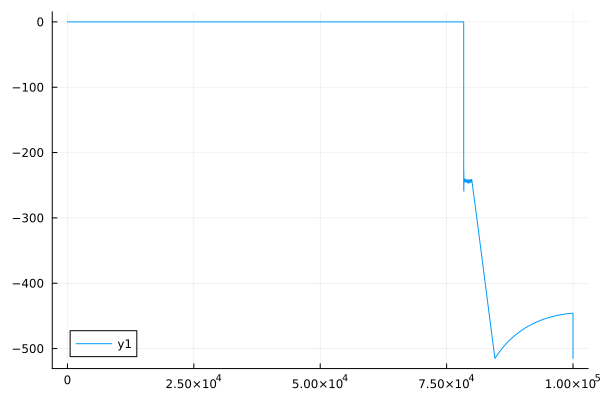

In [34]:
plot(reverse!([hist[i].objvalue for i in eachindex(hist)]))

In [28]:
booster.timestamp

0000-01-01T00:00:22.100

### Optimizer

In [ ]:
#=
how to use

linesearch(                     directly modifies booster.pos
    booster,                    
    hist,                       
    freqs,                      frequency range to optimize on
    α,                          base step length e.g. motorspeed*measurementfrequency
    (objective,[options]),      objective function
    (solver,[options]),         provides step direction p
    (derivative,[options]),     provides derivatives for use by solver
    (step,[options]),           calculates steplength
    (search,[options]),         search mode
    (unstuckinator,[options]);  tries to unstuck system from bad local minima
    ϵgrad=0,                    terminate if norm(gradient) falls below this value,
    maxiter=100,                maximum allowed iterations,
    showtrace=false,            wether to print progress,
    showevery=1,                only print every i iterations,
    unstuckisiter=true          wether an unstucking iteration counts towards maxiter
                                    warning! can run endlessly if false
)

returns trace, access with
trace[iteration].x      disc position
                .obj    objective value
                .g      gradient
                .h      hessian
                .t      timestamp
                .T      summed travel time
=#

In [6]:
trace = linesearch(booster,hist,freqs,booster.vmotor*1e-3,
                    ObjAnalytical,
                    SolverNewton("inv"),
                    Derivator2(1e-5,1e-6,"double"),
                    StepNorm("unit"),
                    SearchExtendedSteps(2000),
                    UnstuckDont;
                    ϵgrad=0.,maxiter=Int(1e2),showtrace=true);

Gradient norm: 4.69e6


Iter: 1, timestamp: 22 seconds
Iter finished. Steps: 2000, Objective value: -361.75



Gradient norm: 6.82e6


Iter: 2, timestamp: 44 seconds
Iter finished. Steps: 2000, Objective value: -491.65



Gradient norm: 8.0e6


Iter: 3, timestamp: 1 minute, 6 seconds
Iter finished. Steps: 190, Objective value: -508.916



Gradient norm: 4.95e6


Iter: 4, timestamp: 1 minute, 30 seconds
Iter finished. Steps: 0, Objective value: -508.916

Stuck. Trying to unstuck.

No unstucking tried. Terminating.
Terminated. 4 Iterations.
Final objective value: -508.916
Elapsed movement time:  1 minute, 31 seconds
Summed movement time:   2 minutes, 53 seconds
Elapsed computing time: 1 second, 924 milliseconds


In [ ]:
#obtain result, booster is now in optimized position
#pos2dist(booster.pos)     #in distance space
booster.pos               #in position space

In [ ]:
#get handy output
plt = analyse(hist,trace,freqsplot; freqs=freqs,div=10)

#savefig(plt[i],"cool_epic_result_wow.svg")